In [ ]:
!pip install pytorch-ignite

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

import os
import torch
import torchvision
import tarfile
import numpy as np
from collections import defaultdict

import torch.nn as nn
import torchvision.transforms as tt
import torch.nn.functional as F

from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

     |████████████████████████████████| 251 kB 4.3 MB/s 


In [ ]:
!nvidia-smi

Tue Jan 25 00:22:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./imagenette2-160.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/imagenette2-160'
print('data directory : ' + str(os.listdir(data_dir)))

lbl_dict = dict(
    n01440764 = 'tench',
    n02102040 = 'English springer',
    n02979186 = 'cassette player',
    n03000684 = 'chain saw',
    n03028079 = 'church',
    n03394916 = 'French horn',
    n03417042 = 'garbage truck',
    n03425413 = 'gas pump',
    n03445777 = 'golf ball',
    n03888257 = 'parachute'
    )

classes = sorted(os.listdir(data_dir + "/train"))
classes.pop(0) # for imagenette2-160
print('classes : '+ str(classes))

labels = []
for x in range(len(classes)) : 
  labels.append(lbl_dict[classes[x]])
print('labels  : '+ str(labels))

  0%|          | 0/99003388 [00:00<?, ?it/s]

data directory : ['val', '.DS_Store', 'train', 'noisy_imagenette.csv']
classes : ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
labels  : ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']


# **1.   Imagenette (160px) Dataset**

In [ ]:
# transform all the images into tensors
train_dir = data_dir + "/train"
train = ImageFolder(train_dir, tt.ToTensor())

val_dir = data_dir + '/val'
val = ImageFolder(val_dir, tt.ToTensor())   

print(f"Training data samples: {len(train)}")
print(f"Validation data samples: {len(val)}")

Training data samples: 9469
Validation data samples: 3925


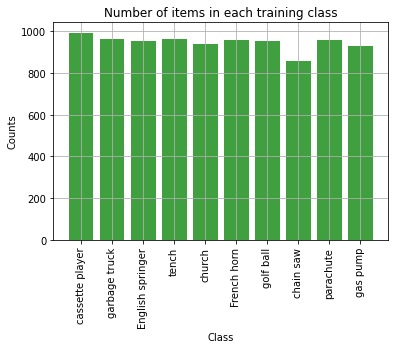

In [ ]:
x_train = []
data_train = []

for root, dirs, files in os.walk(train_dir):
  if root != './data/imagenette2-160/train':
    if files == []:
      continue
    else:
      x_train.append(lbl_dict[root[-9:]])
      data_train.append(len(files))

plt.bar(x_train, data_train, facecolor='g', alpha=0.75)

plt.xlabel('Class')
plt.ylabel('Counts')
plt.title('Number of items in each training class')
# Rotation of the bar names
plt.xticks(x_train, rotation=90)
# plt.subplot_adjust(bottom=0.01, top=0.99)

plt.grid(True)
plt.show()

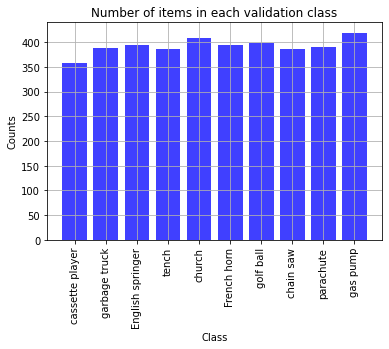

In [ ]:
x_val = []
data_val = []

for root, dirs, files in os.walk(val_dir):
  if root != './data/imagenette2-160/val':
    if files == []:
      continue
    else:
      x_val.append(lbl_dict[root[-9:]])
      data_val.append(len(files))

plt.bar(x_val, data_val, facecolor='b', alpha=0.75)

plt.xlabel('Class')
plt.ylabel('Counts')
plt.title('Number of items in each validation class')
# Rotation of the bar names
plt.xticks(x_val, rotation=90)
# plt.subplots_adjust(bottom=0.4, top=0.99)

plt.grid(True)
plt.show()

## Preprocessing

In [ ]:
channel = []
height = []
width = []
for image,_ in train:
  channel.append(image.shape[0])
  height.append(image.shape[1])
  width.append(image.shape[2])

print("number of channels: {}".format(min(channel)))
print("minimum height: {}, maximum height: {}".format(min(height), max(height)))
print("minimum width : {}, maximum width : {}".format(min(width), max(width)))

number of channels: 3
minimum height: 160, maximum height: 707
minimum width : 160, maximum width : 802


**View of the images transformation**

In [ ]:
def show_example(img,label):
  print('Label: ', lbl_dict[classes[label]])
  plt.imshow(img.permute(1, 2, 0))
  plt.grid(False)
  plt.show()

Label:  cassette player


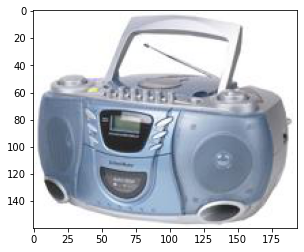

In [ ]:
# First transformation
train_first = tt.Compose([ 
                          tt.ToTensor()
                          ])

train_first_ds = ImageFolder(train_dir, train_first)

show_example(*train_first_ds[2000])

Label:  cassette player


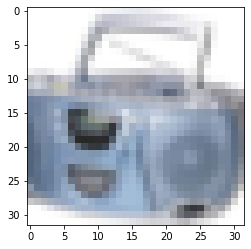

In [ ]:
# Second transformation
train_second = tt.Compose([
                           tt.RandomResizedCrop(32, scale=(0.8,0.99), ratio=(1, 1)),
                           tt.ToTensor()
                           ])

train_second_ds = ImageFolder(data_dir+'/train', train_second)

show_example(*train_second_ds[2000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  cassette player


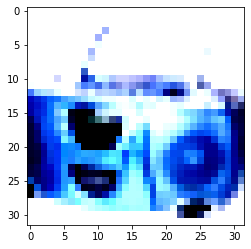

In [ ]:
# Third transformation
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_third = tt.Compose([
                          tt.RandomResizedCrop(32, scale=(0.8,0.99), ratio=(1, 1)),
                          tt.ToTensor(),
                          tt.Normalize(*stats, inplace=True)
                          ])

train_third_ds = ImageFolder(data_dir+'/train', train_third)

show_example(*train_third_ds[2000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  cassette player


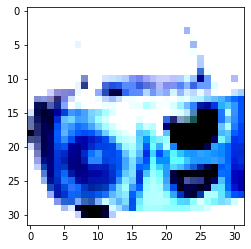

In [ ]:
# Dataset transformation (normalization & data augmentation)
train_tfms = tt.Compose([
                        #  tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                        #  tt.RandomRotate,
                         tt.RandomResizedCrop(32, scale=(0.8,0.99),
                                              ratio=(1, 1)), 
                        #  tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)
                         ])

valid_tfms = tt.Compose([
                         tt.RandomResizedCrop(32, scale=(0.8,0.99),
                                              ratio=(1, 1)),
                         tt.ToTensor(),
                         tt.Normalize(*stats)
                        ])

train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/val',   valid_tfms)

show_example(*train_ds[2000])

**View of the patch embedding on images**

In [ ]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

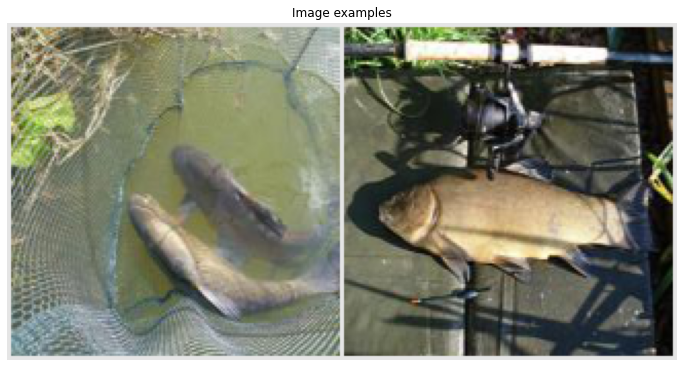

In [ ]:
train_patches = tt.Compose([tt.Resize((160,160)),
                            tt.ToTensor() ])

train_patches_ds = ImageFolder(train_dir, train_patches)

NUM_IMAGES = 2
images = torch.stack([train_patches_ds[i][0] for i in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(images, nrow=NUM_IMAGES, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(12,12))
plt.title("Image examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

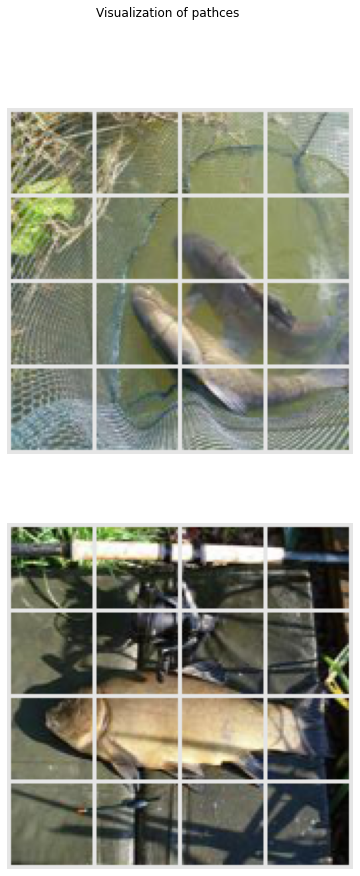

In [ ]:
img_patches = img_to_patch(images, patch_size=40, flatten_channels=False)

fig, ax = plt.subplots(images.shape[0], 1, figsize=(14,14))
fig.suptitle("Visualization of pathces")
for i in range(images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=4, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

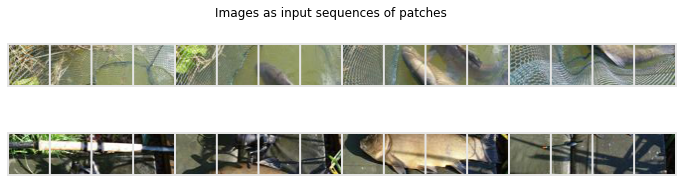

In [ ]:
img_patches = img_to_patch(images, patch_size=40, flatten_channels=False)

fig, ax = plt.subplots(images.shape[0], 1, figsize=(12,3))
fig.suptitle("Images as input sequences of patches")
for i in range(images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=16, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

# **2.   Training and Validation Datasets**


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [ ]:
batch_size = 16 #8, 16
train_dl = DataLoader(train_ds, batch_size, drop_last=True, shuffle=True,
                      num_workers=8, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, drop_last=True, shuffle=True,
                      num_workers=8, pin_memory=True)

for data in train_dl:
    pass

print("Shape of Dataset output\n", train_ds[0][0].shape)
print()
print("Shape of DataLoader output\n", data[0].shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Shape of Dataset output
 torch.Size([3, 32, 32])

Shape of DataLoader output
 torch.Size([16, 3, 32, 32])


**View of a batch of images**

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


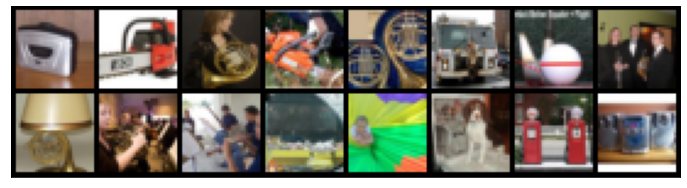

In [ ]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1,3,1,1)
  stds = torch.tensor(stds).reshape(1,3,1,1,)
  return images * stds + means


def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (12,12))
    ax.set_xticks([]), ax.set_yticks([])
    denorm_images = denormalize(images, *stats)
    ax.imshow(make_grid(denorm_images[:64],nrow = 8).permute(1,2,0).clamp(0,1))
    break
    
show_batch(train_dl)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

for (images, labels) in train_dl:
  print(images.is_cuda)
  print(labels.is_cuda)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


True
True


In [ ]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

# ConvMixer Model


In [ ]:
#torch.__version__ should be 1.9
class Residual(nn.Module):
    def __init__(self, residual):
        super().__init__()
        self.residual = residual
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return x + self.gamma * self.residual(x)

class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, groups=groups),
            nn.GELU(),
            nn.BatchNorm2d(out_channels)
        )

class ConvMixerLayer(nn.Sequential):
    def __init__(self, channels, kernel_size):
        super().__init__(
            Residual(ConvBlock(channels, channels, kernel_size, groups=channels)), # Depthwise
            ConvBlock(channels, channels, 1) # Pointwise
        )

class ConvMixer(nn.Sequential):
    def __init__(self, classes, channels, depth, patch_size, kernel_size):
        super().__init__(nn.Sequential(
            # Patch embedding layer
            nn.Sequential(
                nn.Conv2d(3, channels, kernel_size=patch_size, stride=1, groups=1),
                nn.GELU(),
                nn.BatchNorm2d(channels)),
            # ConvMixer layer
            *[ ConvMixerLayer(channels, kernel_size) for _ in range(depth) ],
            # Head
            nn.Sequential(
                nn.AdaptiveAvgPool2d((1,1)),
                nn.Flatten(),
                nn.Dropout(.3),
                nn.Linear(channels, classes))
        ))

In [ ]:
model = ConvMixer(classes=10, channels=256, depth=12, patch_size=2, kernel_size=7)
model.to(device)
model.apply(init_linear)

ConvMixer(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 256, kernel_size=(2, 2), stride=(1, 1))
      (1): GELU()
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvMixerLayer(
      (0): Residual(
        (residual): ConvBlock(
          (0): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
          (1): GELU()
          (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ConvBlock(
        (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): GELU()
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ConvMixerLayer(
      (0): Residual(
        (residual): ConvBlock(
          (0): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
          (1): GELU()
          (2): BatchNorm2d(256, eps=1e-05, momentum=0.1

In [ ]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 961,814


In [ ]:
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.BatchNorm2d,)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, Residual) and param_name.endswith("gamma"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    #assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = separate_parameters(model)
    
    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

In [ ]:
loss = nn.CrossEntropyLoss()

optimizer = get_optimizer(model, learning_rate=1e-3, weight_decay=0)
trainer = create_supervised_trainer(model, optimizer, loss, device=device)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3,
                                             steps_per_epoch=len(train_dl),
                                             epochs=100)
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step())
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
history = defaultdict(list)

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(valid_dl)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

In [ ]:
# torch.cuda.empty_cache()
trainer.run(train_dl, max_epochs=30)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1/30 - train: loss 1.823; val: loss 1.807 accuracy 0.393
2/30 - train: loss 1.690; val: loss 1.670 accuracy 0.446
3/30 - train: loss 1.563; val: loss 1.563 accuracy 0.498
4/30 - train: loss 1.457; val: loss 1.444 accuracy 0.541
5/30 - train: loss 1.338; val: loss 1.333 accuracy 0.582
6/30 - train: loss 1.252; val: loss 1.227 accuracy 0.618
7/30 - train: loss 1.164; val: loss 1.149 accuracy 0.645
8/30 - train: loss 1.089; val: loss 1.104 accuracy 0.658
9/30 - train: loss 1.028; val: loss 1.045 accuracy 0.669
10/30 - train: loss 1.046; val: loss 1.002 accuracy 0.678
11/30 - train: loss 0.903; val: loss 0.956 accuracy 0.702
12/30 - train: loss 0.905; val: loss 0.879 accuracy 0.718
13/30 - train: loss 0.821; val: loss 0.856 accuracy 0.730
14/30 - train: loss 0.774; val: loss 0.848 accuracy 0.733
15/30 - train: loss 0.741; val: loss 0.802 accuracy 0.748
16/30 - train: loss 0.714; val: loss 0.762 accuracy 0.760
17/30 - train: loss 0.617; val: loss 0.743 accuracy 0.768
18/30 - train: loss 0.6

State:
	iteration: 17730
	epoch: 30
	epoch_length: 591
	max_epochs: 30
	output: 0.6388840079307556
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class '__main__.DeviceDataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

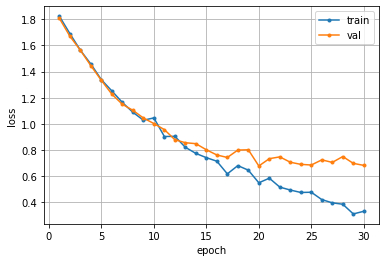

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['train loss']) + 1)
ax.plot(xs, history['train loss'], '.-', label='train')
ax.plot(xs, history['val loss'], '.-', label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.grid()
plt.show()

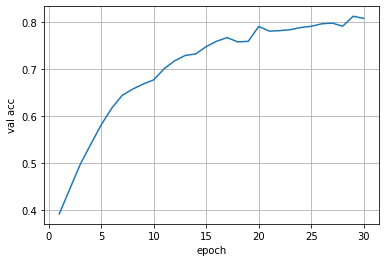

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['val acc']) + 1)
ax.plot(xs, history['val acc'], '-')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
ax.grid()
plt.show()

# ViT Model

In [ ]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )


    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

class VisionTransformer(nn.Sequential):

    def __init__(self, num_classes, embed_dim, hidden_dim, num_channels, num_heads, num_layers, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))


    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [ ]:
model_vit = VisionTransformer(num_classes=10, embed_dim = 128, hidden_dim = 256,
                              num_channels=3, num_heads=8, num_layers=6, 
                              patch_size=4, num_patches=64, dropout=0.2)
model_vit.to(device)
model_vit.apply(init_linear)

VisionTransformer(
  (input_layer): Linear(in_features=48, out_features=128, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (layer_norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): GELU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=256, out_features=128, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (layer_norm_2): LayerNorm((128,), eps=1

In [ ]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model_vit.parameters())))

Number of parameters: 811,146


In [ ]:
loss = nn.CrossEntropyLoss()

optimizer = get_optimizer(model_vit, learning_rate=1e-3, weight_decay=0.3)
trainer_vit = create_supervised_trainer(model_vit, optimizer, loss, device=device)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3,
                                             steps_per_epoch=len(train_dl),
                                             epochs=100)
trainer_vit.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step())
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer_vit, "loss")
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}
evaluator = create_supervised_evaluator(model_vit, metrics=val_metrics, device=device)
history2 = defaultdict(list)

In [ ]:
@trainer_vit.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history2['train loss'].append(train_loss)
    
    evaluator.run(valid_dl)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history2['val loss'].append(val_loss)
    history2['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

In [ ]:
# torch.cuda.empty_cache()
trainer_vit.run(train_dl, max_epochs=30)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1/30 - train: loss 2.298; val: loss 2.099 accuracy 0.228
2/30 - train: loss 2.194; val: loss 2.062 accuracy 0.259
3/30 - train: loss 2.153; val: loss 2.010 accuracy 0.301
4/30 - train: loss 2.103; val: loss 1.955 accuracy 0.316
5/30 - train: loss 1.980; val: loss 1.921 accuracy 0.322
6/30 - train: loss 1.934; val: loss 1.897 accuracy 0.337
7/30 - train: loss 1.873; val: loss 1.882 accuracy 0.355
8/30 - train: loss 1.911; val: loss 1.828 accuracy 0.365
9/30 - train: loss 1.788; val: loss 1.775 accuracy 0.398
10/30 - train: loss 1.736; val: loss 1.729 accuracy 0.403
11/30 - train: loss 1.693; val: loss 1.632 accuracy 0.442
12/30 - train: loss 1.605; val: loss 1.573 accuracy 0.469
13/30 - train: loss 1.566; val: loss 1.597 accuracy 0.465
14/30 - train: loss 1.419; val: loss 1.438 accuracy 0.520
15/30 - train: loss 1.399; val: loss 1.483 accuracy 0.513
16/30 - train: loss 1.302; val: loss 1.414 accuracy 0.539
17/30 - train: loss 1.369; val: loss 1.453 accuracy 0.532
18/30 - train: loss 1.2

State:
	iteration: 17730
	epoch: 30
	epoch_length: 591
	max_epochs: 30
	output: 1.1618646383285522
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class '__main__.DeviceDataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

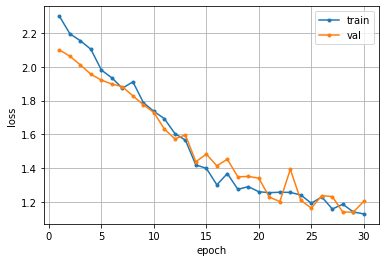

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history2['train loss']) + 1)
ax.plot(xs, history2['train loss'], '.-', label='train')
ax.plot(xs, history2['val loss'], '.-', label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.grid()
plt.show()

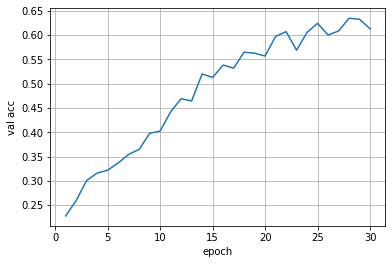

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history2['val acc']) + 1)
ax.plot(xs, history2['val acc'], '-')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
ax.grid()
plt.show()

# ResNet Model

In [ ]:
def conv_block(in_channels, out_channels, kernel_size, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Sequential):
    def __init__(self, classes, channels, kernel_size):
        super().__init__()
        
        self.conv1 = conv_block(3, channels, kernel_size)
        self.conv2 = conv_block(channels, 2*channels, kernel_size, pool=True)
        self.res1 = nn.Sequential(conv_block(2*channels, 2*channels, kernel_size),
                                  conv_block(2*channels, 2*channels, kernel_size))
        
        self.conv3 = conv_block(2*channels, 4*channels, kernel_size, pool=True)
        self.conv4 = conv_block(4*channels, 8*channels, kernel_size, pool=True)
        self.res2 = nn.Sequential(conv_block(8*channels, 8*channels, kernel_size),
                                  conv_block(8*channels, 8*channels, kernel_size))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(8*channels, classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [ ]:
model_rn = ResNet9(classes=10, channels=32, kernel_size=3)
model_rn.to(device)
model_rn.apply(init_linear)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [ ]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model_rn.parameters())))

Number of parameters: 1,647,242


In [ ]:
loss = nn.CrossEntropyLoss()

optimizer = get_optimizer(model_rn, learning_rate=1e-3, weight_decay=0)
trainer_rn = create_supervised_trainer(model_rn, optimizer, loss, device=device)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3,
                                             steps_per_epoch=len(train_dl),
                                             epochs=100)
trainer_rn.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step())
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer_rn, "loss")
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}
evaluator = create_supervised_evaluator(model_rn, metrics=val_metrics, device=device)
history3 = defaultdict(list)

In [ ]:
@trainer_rn.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history3['train loss'].append(train_loss)
    
    evaluator.run(valid_dl)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history3['val loss'].append(val_loss)
    history3['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

In [ ]:
# torch.cuda.empty_cache()
trainer_rn.run(train_dl, max_epochs=30)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1/30 - train: loss 2.879; val: loss 1.643 accuracy 0.454
2/30 - train: loss 2.334; val: loss 1.446 accuracy 0.523
3/30 - train: loss 2.092; val: loss 1.332 accuracy 0.571
4/30 - train: loss 1.927; val: loss 1.337 accuracy 0.583
5/30 - train: loss 1.754; val: loss 1.267 accuracy 0.602
6/30 - train: loss 1.545; val: loss 1.213 accuracy 0.627
7/30 - train: loss 1.503; val: loss 1.357 accuracy 0.613
8/30 - train: loss 1.429; val: loss 1.094 accuracy 0.666
9/30 - train: loss 1.328; val: loss 1.181 accuracy 0.641
10/30 - train: loss 1.263; val: loss 1.303 accuracy 0.622
11/30 - train: loss 1.169; val: loss 1.082 accuracy 0.675
12/30 - train: loss 1.091; val: loss 1.049 accuracy 0.682
13/30 - train: loss 1.104; val: loss 1.060 accuracy 0.670
14/30 - train: loss 0.911; val: loss 1.008 accuracy 0.689
15/30 - train: loss 0.905; val: loss 0.893 accuracy 0.722
16/30 - train: loss 0.863; val: loss 0.909 accuracy 0.714
17/30 - train: loss 0.827; val: loss 0.842 accuracy 0.733
18/30 - train: loss 0.7

State:
	iteration: 17730
	epoch: 30
	epoch_length: 591
	max_epochs: 30
	output: 0.17092904448509216
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class '__main__.DeviceDataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

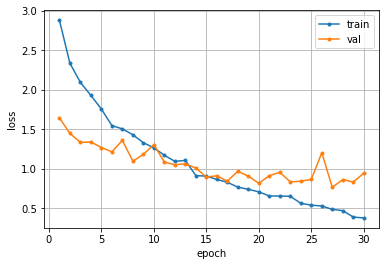

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['train loss']) + 1)
ax.plot(xs, history3['train loss'], '.-', label='train')
ax.plot(xs, history3['val loss'], '.-', label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.grid()
plt.show()

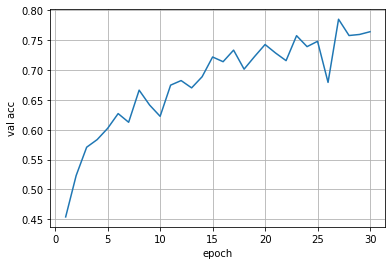

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history3['val acc']) + 1)
ax.plot(xs, history3['val acc'], '-')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
ax.grid()
plt.show()

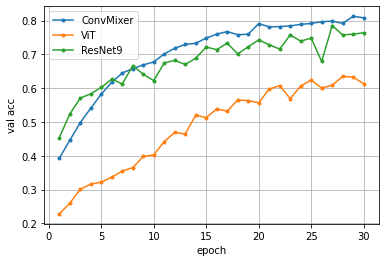

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history3['val acc']) + 1)
ax.plot(xs, history['val acc'], '.-', label='ConvMixer')
ax.plot(xs, history2['val acc'], '.-', label='ViT')
ax.plot(xs, history3['val acc'], '.-', label='ResNet9')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
ax.legend()
ax.grid()
plt.show()